In [2]:
import numpy as np
from codebase.file_utils import save_obj, load_obj, make_folder, path_backslash
from pdb import set_trace
from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize
from codebase.plot import *
from scipy import stats
import matplotlib.pyplot as plt

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [3]:
def get_pi_z(z, alpha, beta):
    exp_eta = np.exp(alpha +  z @ beta.T)
    return exp_eta/(1+exp_eta)


In [4]:

np.random.seed(5)
theta_t=dict()
alpha = np.array([0, 0.1, -0.1,-0.2,0.2])
beta = np.array([[1,0.8,0.9,0.5,1.3]]).T
z_t = np.array([[-2]])

y_t = np.random.binomial(1, get_pi_z(z_t, alpha, beta))
y_t

array([[0, 1, 0, 1, 0]])

In [5]:
def get_log_likelihood(z,y,alpha, beta):
    pi_z = get_pi_z(z, alpha, beta)
    s1 = np.sum(y*np.log(pi_z)+((1.-y)*np.log(1.-pi_z)))
#     s2 = -.5 * np.sum(z**2)
    return s1

def logprior(z):
    return norm.logpdf(z)

def get_neg_log_likelihood(z,y,alpha, beta):
    return - get_log_likelihood(z,y,alpha, beta)

def get_neg_posterior(z,y,alpha, beta):
    return - (get_log_likelihood(z,y,alpha, beta)+ norm.logpdf(z))


lglk = get_log_likelihood(z_t, y_t, alpha, beta) 
lglk

-3.5178466668006667

In [6]:
### analytical posterior pdf
x = np.linspace(-3,3,1000)
lposts = np.zeros(1000)
for i in range(1000):
    z_t = x[i].reshape((1,1))
    lposts[i] = get_log_likelihood(z_t, y_t, alpha, beta) + logprior(z_t)
posts = np.exp(lposts)
posts = posts/np.sum(posts*6/1000)

In [7]:
## simple Laplace approx

M = x[np.argmax(posts)].reshape((1,1)) # mean at the mode
h = 0.000001  # numerical second derivative
f1 = get_log_likelihood(M+h, y_t,alpha,beta) + logprior(M+h)
f2 = get_log_likelihood(M, y_t,alpha,beta) + logprior(M)
f3 = get_log_likelihood(M-h, y_t,alpha,beta) + logprior(M-h)
V=-(h*h)/(f1-2*f2+f3) # variance being 2nd derivative evaluated at the mode.

In [9]:
def get_grad_pi_z(z, alpha, beta):
    exp_eta = np.exp(alpha +  z @ beta.T)
    return (exp_eta * beta.T)/(1+exp_eta)**2

In [10]:
def get_fisher_information(z, y, alpha, beta):
    pi_z = get_pi_z(z, alpha, beta)
    grad_pi_z = get_grad_pi_z(z, alpha, beta)
    r1 =grad_pi_z**2
    r2 =pi_z*(1.-pi_z)
    return 1. + np.sum(r1/r2)

get_fisher_information(z_t, y_t, alpha, beta)

1.2113499213962307

In [13]:
def get_laplace_approx(y, alpha, beta):
    res = minimize(get_neg_posterior, np.array([[1]]), args=(y, alpha, beta), method='BFGS')
    cov_matrix = get_fisher_information(res.x, y, alpha, beta)
    return multivariate_normal(mean = res.x, cov = cov_matrix**(-1))
lapldist =  get_laplace_approx(y_t, alpha, beta)
laplace_samples = lapldist.rvs(size = 10000)

In [14]:
laplace_pdf = lapldist.pdf(x)

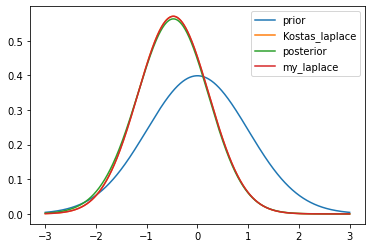

In [17]:
plt.plot(x,norm.pdf(x),label='prior')
plt.plot(x,np.squeeze(norm.pdf(x,M,np.sqrt(V))),label='Kostas_laplace')
plt.plot(x,posts,label='posterior')
plt.plot(x,laplace_pdf,label='my_laplace')
plt.legend()